In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display

In [53]:
# programs_to_show = ['sequential_frontier_simd', 'mpi_priority_frontier_simd', 'mpi_priority_frontier', 'mpi_no_master_frontier_simd']
programs_to_show = ['mpi_priority_frontier_simd', 'mpi_priority_frontier', 'mpi_no_master_frontier_simd']
new_program = 'mpi_priority_frontier_simd'
assert new_program in programs_to_show
old_program = 'mpi_no_master_frontier_simd'
assert old_program in programs_to_show

upper_scale = 4

In [54]:
raw_benchmark_results = []
for path in glob.glob('../benchmarks/2020-12-09-euler-plan-batch-test/*.csv'):
    raw_benchmark_results.append(pd.read_csv(path))
raw_benchmark_results = pd.concat(raw_benchmark_results)

raw_benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,micros_input,micros_precompute,micros_until_len,micros_edit_script,mpi_procs
147,26,add,60000,0.25,0.0,zipf,0,0,mpi_priority_frontier,19748,0,2198,0,16.0
15,47,addremove,80000,0.75,0.0,zipf,0,0,mpi_priority_frontier,18370,0,289527,0,64.0
45,3,add,20000,0.50,0.0,zipf,0,0,mpi_no_master_frontier_simd,5581,0,588174,0,1.0
123,48,independent,80000,1.00,0.0,zipf,0,0,mpi_priority_frontier,15561,0,2064437,0,16.0
82,4,remove,20000,0.50,0.0,zipf,0,1,mpi_priority_frontier,2360,0,7938,0,32.0


In [55]:
indexed_benchmark_results = raw_benchmark_results.set_index(['generation_config_i', 'regen_i', 'diff_program', 'repetition_i'])
indexed_benchmark_results

input_strategy  \
generation_config_i regen_i diff_program               repetition_i                  
64                  0       sequential_frontier_simd   0                 addremove   
                                                       1                 addremove   
                                                       2                 addremove   
18                  0       sequential_frontier_simd   0                 addremove   
                                                       1                 addremove   
...                                                                            ...   
70                  0       mpi_priority_frontier_simd 1                 addremove   
                                                       2                 addremove   
19                  0       mpi_priority_frontier_simd 0                       add   
                                                       1                       add   
                                                       2                       add   

                                                                     input_length_1  \
generation_config_i regen_i diff_program               repetition_i                   
64                  0       sequential_frontier_simd   0                     100000   
                                                       1                     100000   
                                                       2                     100000   
18                  0       sequential_frontier_simd   0                      40000   
                                                       1                      40000   
...                                                                             ...   
70                  0       mpi_priority_frontier_simd 1                     120000   
                                                       2                     120000   
19                  0       mpi_priority_frontier_simd 0                      40000   
                                                       1                      40000   
                                                       2                      40000   

                                                                     input_change_strength  \
generation_config_i regen_i diff_program               repetition_i                          
64                  0       sequential_frontier_simd   0                              1.00   
                                                       1                              1.00   
                                                       2                              1.00   
18                  0       sequential_frontier_simd   0                              0.50   
                                                       1                              0.50   
...                                                                                    ...   
70                  0       mpi_priority_frontier_simd 1                              0.50   
                                                       2                              0.50   
19                  0       mpi_priority_frontier_simd 0                              0.75   
                                                       1                              0.75   
                                                       2                              0.75   

                                                                     input_chunkiness  \
generation_config_i regen_i diff_program               repetition_i                     
64                  0       sequential_frontier_simd   0                          0.0   
                                                       1                          0.0   
                                                       2                          0.0   
18                  0       sequential_frontier_simd   0                          0.0   
                                                       1    

In [56]:
unique_regen_i_values = sorted(np.unique(indexed_benchmark_results.index.get_level_values('regen_i').values))
assert(unique_regen_i_values == [0])

unique_mpi_procs_values = sorted(indexed_benchmark_results['mpi_procs'].dropna().unique())
unique_mpi_procs_values

[1.0, 8.0, 16.0, 32.0, 64.0]

In [77]:
def plot_speedup_vs_cores(filter_cb, index_col):
    fig, ax = plt.subplots(len(unique_mpi_procs_values), 2, figsize=(14, 14), sharex=True)

    for mpi_procs_i, mpi_procs in enumerate(unique_mpi_procs_values):
        temp = indexed_benchmark_results
        temp = temp[temp['mpi_procs'] == mpi_procs]
        temp = temp.groupby(['generation_config_i', 'diff_program']).min()
        temp = temp[temp.index.get_level_values('diff_program').isin(programs_to_show)]
        temp = filter_cb(temp)
        temp = temp.set_index(index_col, append=True)
        temp = temp.unstack('diff_program')['micros_until_len']
        temp = temp.droplevel('generation_config_i')
        temp = temp.sort_index()

        temp.plot(ax=ax[mpi_procs_i][0], legend=(mpi_procs_i == 0), title=f'Wall time with {int(mpi_procs)} cores');
        (temp[old_program] / temp[new_program]).plot(ax=ax[mpi_procs_i][1], ylim=(0, upper_scale), title=f'{old_program} / {new_program}');
        ax[mpi_procs_i][1].grid(axis='y')

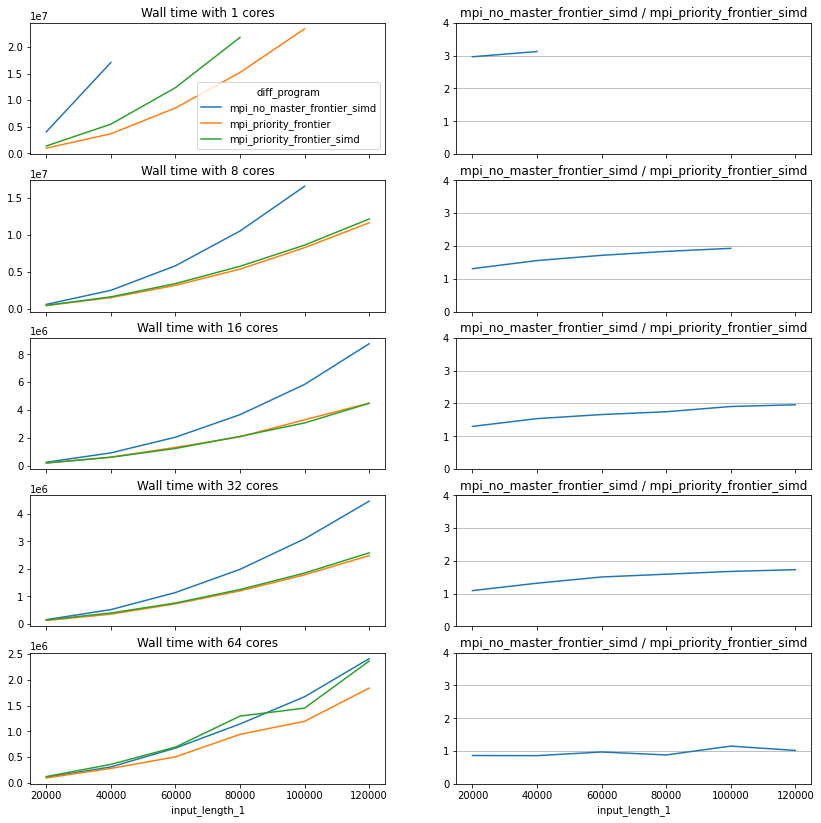

In [78]:
plot_speedup_vs_cores(
    lambda temp: temp[(temp['input_strategy'] == 'independent')],
    'input_length_1',
)

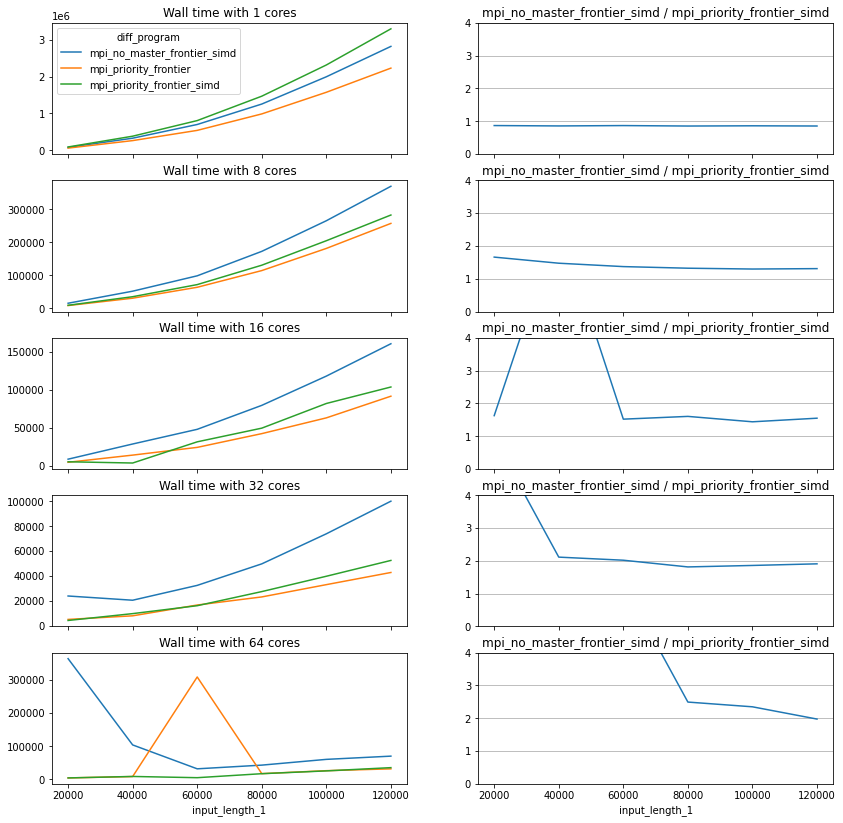

In [79]:
plot_speedup_vs_cores(
    lambda temp: temp[(temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == 0.25) & (temp['input_chunkiness'] == 0)],
    'input_length_1',
)

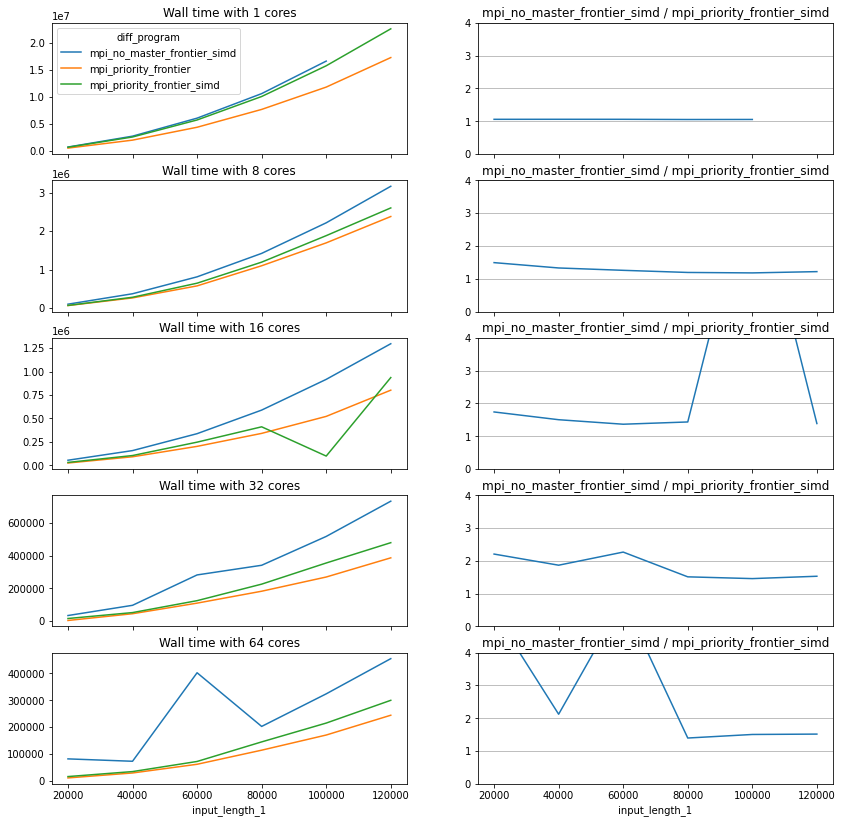

In [80]:
plot_speedup_vs_cores(
    lambda temp: temp[(temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == 0.75) & (temp['input_chunkiness'] == 0)],
    'input_length_1',
)

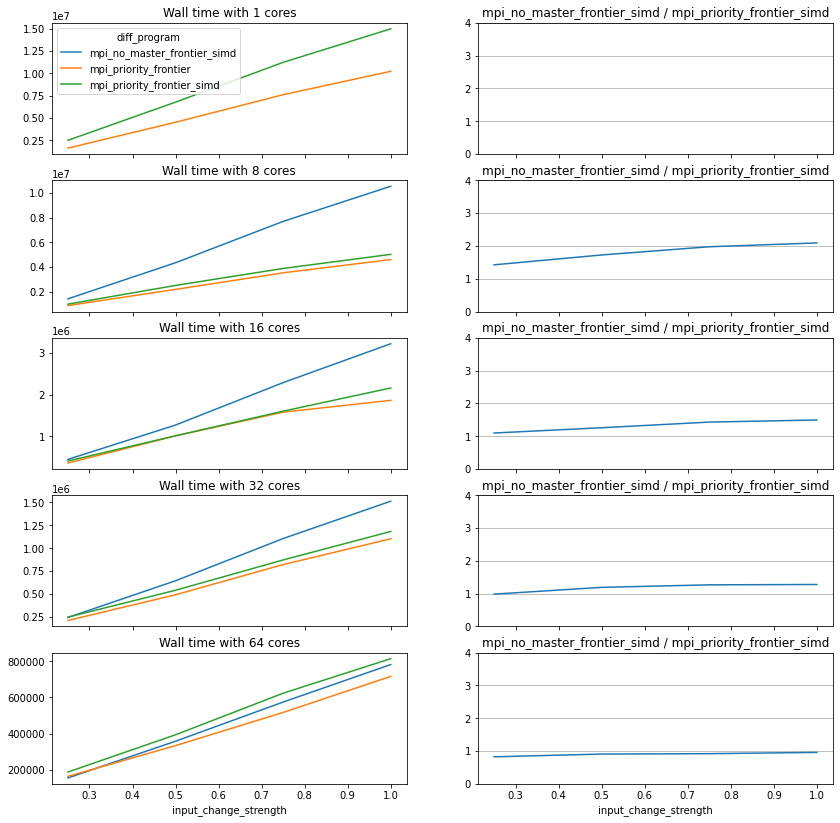

In [81]:
plot_speedup_vs_cores(
    lambda temp: temp[(temp['input_strategy'] == 'addremove') & (temp['input_length_1'] == temp['input_length_1'].max()) & (temp['input_chunkiness'] == 0)],
    'input_change_strength',
)